In [3]:
import os
os.listdir('.')

['Untitled1.ipynb',
 'playWav.ipynb',
 'ref_resnet',
 '#ResNet_test.py#',
 '.git',
 'LCNNtest.py',
 'T_1000601.wav',
 'Untitled.ipynb',
 '.ipynb_checkpoints',
 'LCNNtest.py~',
 'ResNet_test.py',
 'LCNN_prac.ipynb',
 'resnet.py~',
 'classification.ipynb',
 'README.md']

In [4]:
a_file = 'T_1000601.wav'

In [5]:
import IPython.display as ipd
ipd.Audio(a_file) # load a local WAV file

In [8]:
import librosa

In [27]:
signal, sr = librosa.load(a_file, sr = 16000)


In [28]:
sr

16000

In [29]:
signal.shape

(28376,)

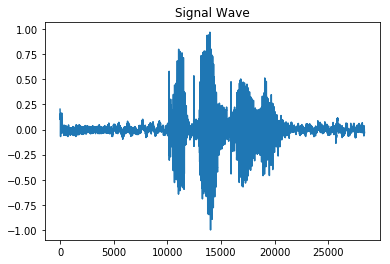

In [30]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.title('Signal Wave')
plt.plot(signal)
plt.show()

good source: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html


In [31]:
frame_size = 0.025; frame_stride = 0.0125; sample_rate = sr

In [34]:
import numpy as np
pre_emphasis = 0.97

In [35]:
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])


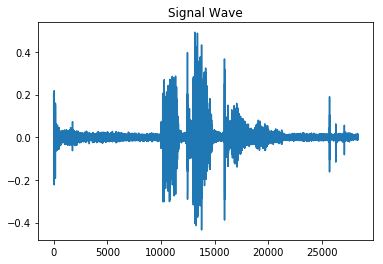

In [36]:
plt.figure(1)
plt.title('Signal Wave')
plt.plot(emphasized_signal)
plt.show()

In [39]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [41]:
frames.shape

(140, 400)

Apply hamming window

In [43]:
frames *= np.hamming(frame_length)

In [45]:
NFFT = 512

In [46]:
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [56]:
pow_frames.shape

(140, 257)

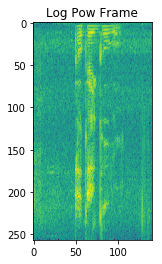

In [63]:

plt.figure(1)
plt.title('Log Pow Frame')
imgplot = plt.imshow(np.log(pow_frames.T))


In [65]:
nfilt = 50

In [66]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [67]:
filter_banks.shape

(140, 50)

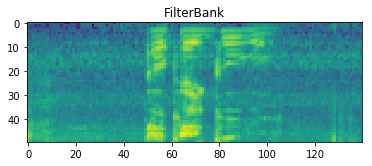

In [68]:

plt.figure(1)
plt.title('FilterBank')
imgplot = plt.imshow(filter_banks.T)


In [76]:
import scipy
num_ceps=30

In [77]:
mfcc = scipy.fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13


In [78]:
mfcc.shape

(140, 30)

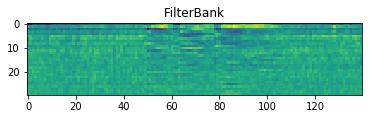

In [79]:

plt.figure(1)
plt.title('FilterBank')
imgplot = plt.imshow(mfcc.T)


CQT from librosa

In [95]:
CQTf = np.abs(librosa.core.cqt(signal, sr=16000, fmin=20, n_bins=100, filter_scale=1))

In [96]:
CQTf

array([[0.19374313, 0.19357501, 0.19068453, ..., 0.40334911, 0.40374633,
        0.40388186],
       [0.07089581, 0.06963641, 0.07117055, ..., 0.29235564, 0.32107908,
        0.3270134 ],
       [0.01556548, 0.01680047, 0.01836885, ..., 0.31121185, 0.31353897,
        0.31392529],
       ...,
       [0.00156486, 0.03005733, 0.02686778, ..., 0.00386728, 0.00215172,
        0.00293501],
       [0.00205062, 0.0227799 , 0.01434508, ..., 0.00540999, 0.00302383,
        0.00614954],
       [0.01049745, 0.00704212, 0.00945615, ..., 0.00500105, 0.00199392,
        0.00597428]])

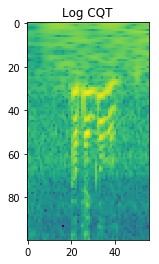

In [97]:

plt.figure(1)
plt.title('Log CQT')
imgplot = plt.imshow(np.log(CQTf))

In [58]:
filter_banks

array([[ -87.79054945, -313.07119549,  -92.74644316, ...,  -38.03520072,
         -38.7725075 ,  -52.96292922],
       [ -98.27825843, -313.07119549, -100.21020082, ...,  -66.57592505,
         -63.61932328,  -74.38977274],
       [ -87.50074446, -313.07119549,  -95.549539  , ...,  -68.72859841,
         -72.12304869,  -77.12424692],
       ...,
       [ -97.33218001, -313.07119549,  -89.66707729, ...,  -66.17845443,
         -66.11046615,  -87.34996431],
       [ -97.36655018, -313.07119549, -103.19442538, ...,  -78.86093236,
         -83.91932131,  -84.8457901 ],
       [-105.5103504 , -313.07119549, -121.88471092, ...,  -84.19995909,
         -82.79499266,  -94.85555225]])

In [ ]:


emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

frames *= np.hamming(frame_length)
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum




In [ ]:
        if self.samp_sec == None:
            samp_sec = len(data)/sample_rate
        else:
            samp_sec = self.samp_sec

        if len(data) > sample_rate * samp_sec:
            n_samp = len(data) // int(sample_rate * samp_sec)
            signal = []
            for i in range(n_samp):
                signal.append(data[int(sample_rate * samp_sec)*i : (int(sample_rate * samp_sec)*(i+1))])
        else:
            n_samp = 1
            signal = np.zeros(int(sample_rate * samp_sec, ))
            for i in range(int(sample_rate * samp_sec) // len(data)):
                signal[(i)*len(data) : (i+1)*len(data)] = data
            num_last = int(sample_rate * samp_sec) - len(data)*(i+1)
            signal[(i+1)*len(data) : int(sample_rate*samp_sec)] = data[:num_last]
            signal = [signal]


        for i in range(n_samp):
            if self.pre_emphasis:
                emphasized_signal = np.append(signal[i][0], signal[i][1:] - self.pre_emphasis*signal[i][:-1])
            else:
                emphasized_signal = signal[i]

            frame_length, frame_step = self.frame_size * sample_rate, self.frame_stride * sample_rate # Convert from seconds

            signal_length = len(emphasized_signal)
            frame_length = int(round(frame_length))
            frame_step = int(round(frame_step))

            num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) # Make sure that we have at least 1 frame
            pad_signal_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_signal_length - signal_length))
            pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
            indicies = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_signal[indicies.astype(np.int32, copy=False)]
            frames *= np.hamming(frame_length) # window

            # Fourier-Transform and Power Spectrum
            pow_frames = self.feature_pow(frames)

            Sig.append(pow_frames.T)

        return Sig
